In [2]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 28.0 MB/s eta 0:00:00


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                 Text Sentiment     Score  \
0                                             배공빠르고 굿   LABEL_0  0.552131   
1                       택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고   LABEL_0  0.538039   
2   아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...   LABEL_0  0.544670   
3   선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...   LABEL_0  0.537945   
4                   민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ   LABEL_0  0.533247   
5   비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...   LABEL_0  0.538558   
6   주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...   LABEL_0  0.546318   
7                           넉넉한 길이로 주문했는데도 안 맞네요 별로예요   LABEL_0  0.543071   
8                           보폴이 계속 때처럼 나오다가 지금은 안나네요~   LABEL_0  0.533342   
9   110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...   LABEL_0  0.535833   
10                              사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ   LABEL_0  0.549662   
11                            베이지 색 구매했는데 약간 살색에 가까워요   LABEL_0  0.523403   

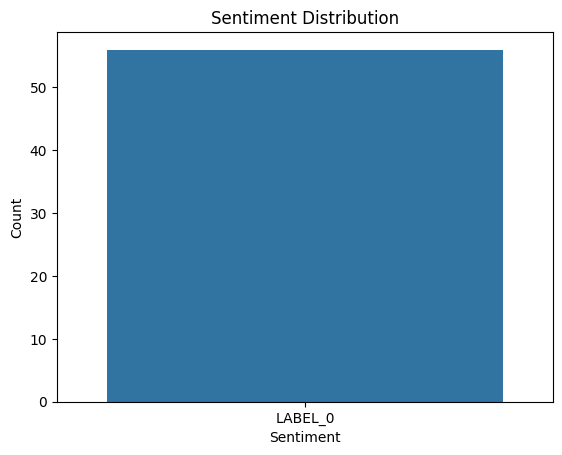

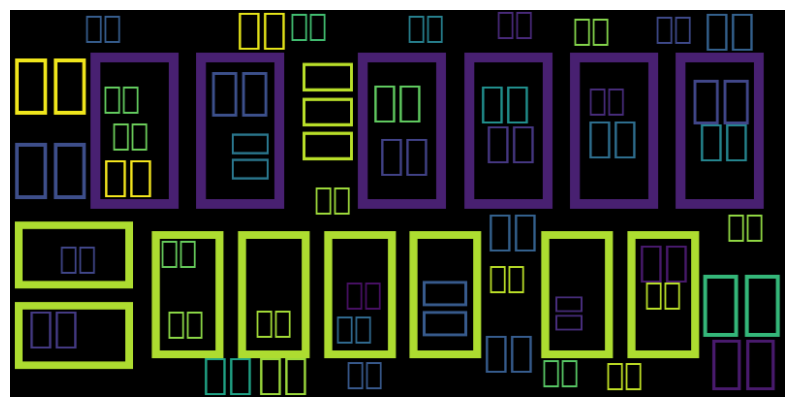

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt
from wordcloud import WordCloud

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# 리뷰 데이터
texts = [
    "배공빠르고 굿",
    "택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고",
    "아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.",
    "선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..",
    "민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ",
    "비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적으로 보였는데 생각보다 진짜 별로입니다.",
    "주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고 아무런 연락을 받을수가 없으니 답답하신 분들은 다른곳에서 사시는거 추천드립니다",
    "넉넉한 길이로 주문했는데도 안 맞네요 별로예요",
    "보폴이 계속 때처럼 나오다가 지금은 안나네요~",
    "110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신축성없는 일반실로 되어있어 빅사이즈임에도 빅사이즈같지않아요. 입고벗을때 편하게 밴딩부분이 늘어나고 입었을때도 밴딩이 잡아주어야하는데 말이죠.",
    "사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ",
    "베이지 색 구매했는데 약간 살색에 가까워요",
    "화면빨인가봐요;; 노란컬러가 돋보여요;; 저렴한맛에 그냥 씁니다",
    "별루 ㅏㅛㅇ치ㅗ티ㅓ치ㅗ탛캏타ㅗ티ㅗ티ㅗ티ㅛ티ㅛ티ㅗㅗㅗ치ㅕ치ㅕ쳐ㅣ처ㅣ치ㅓ처ㅣ펴ㅣ쳐ㅣ치ㅕㅐㅛㅌ쵸ㅔ려ㅔㅎ",
    "촉감도 좋고 무게감이나 핏도 편합니다",
    "불멍하기좋고 사이즈도 너무 좋아요",
    "재구매 친구들이 좋은 향 난다고 해요",
    "실내에서 신는건지 몰랐어요",
    "재구매 다 좋은데 하나가 이상하네요",
    "가게를 운영하는 사장님께서 대신 구매 해달라고 하셔서 구매하게되었는데 가게에 달아놓으니까 이쁘네요",
    "가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜린데...",
    "화장이 깨끗하게 지워지지않아요 거품이생기고 오랫동안 문질러서 씻어내야하지만 세정력이 별로인듯해요",
    "남자 애들 인데 너무 좋아요 유해성분없어 초등들도 바르기좋아요",
    "채집통이 결착이 안됩니다. 채집통이 결착이 안되서 커터칼로 결착 부분과 모서리 부분을 깍아 냈더니 겨우 결착이 됩니다.해당 부분은 제품 불량 이슈 같구요 보내시기 전에 최소한의 테스트는 하고 보내주세요.",
    "재구매 늘 사는 흙이에요 팽이들이 젤 좋아해요 빠른배송 감사합니다",
    "처음 쓸때만 좋고 쓰다보니 의자뺄때 소리 계속 나요 그래서 붙이는부직포 덧붙였는데 여전히 끌리네요 비추에요 테니스공으로 살껄 이쁜거 산다고 이거 사서 후회되요",
    "배송기사나, 판매하는 회사나 불친절하고 불쾌합니다. 서비스면에선 최악이네요 제품은 그럭저럭 쓸만합니다. 싼게 비지떡 마인드부터 갖추고 장사하시길바랍니다. 이익에 눈",
    "저렴해서 구매 했지만 바지 완성도 떨어짐~~^^;",
    "사용이 불편하고 잘빠지네요ㅜ",
    "양은 많은데 맛은 없었습니다",
    "설치할때 전압이 넘 높아 퓨즈 나갔어여",
    "첨에받았을땐 너무튼튼하구 칸막이도있구 넘맘에들었는데요... 지금도맘에는들어요..근데....먼지가 먼지가 세상먼지다묻어요ㅠㅠ흑흑ㅠ 집에가만히 뒀는데도 먼지가다묻어있어요ㅠ 한번들고 그냥 모셔두었어요ㅜㅜ 까만색은 넘나비추입니다ㅠ 아이보리로살껄...ㅠ",
    "휴대폰 각이 잘 안나옴 노트9 사용 얇은 케이스 꺼도 잘 빠지지가 않네요 진짜 불편한건 각도가 조절이 너무 조금 된다는 점 입니다,,,,",
    "너무 생각보다 고급스럽",
    "가볍고 좋아요. 옵션에 파우치도 있었으면 얼마나 좋았을까 아쉽네요. 따로 구매 했어요. 잘 사용할께요.",
    "총 4개 샀는데,사용하기 전에 부드러운 물티슈로 닦았는데,프린트가 번졌네요 교환하기가 귀찮아서 그냥 쓰지만 아쉽네요",
    "모기가 않들어가요ᆢ",
    "선물준사람도 받은사람도 모두 만족했어요^^",
    "예쁘고 심플해서 샀는데. 재질이 깔끄러워요. 살에 자국 다 베이고ㅠㅠ....폭망이에요. 재대로 확인안한 제 잘못이죠;;; 참고로 싱글세트 2. 퀸세트 1 샀습니다.",
    "고정이 잘되기는 하는데 많이 쓰면 떡진것 처럼 보일까봐 걱정되서 많이 못쓰겠어요",
    "맛있어서 주문합니다. 카페갈 필요없음",
    "진짜 너무하시네요 배송이늦는건 엄절수없다하고 참앗지만 밑에 서랍이 금방 안되서 AS되냐고 물어봣는데 전화도 안받고 10시에 톡을보냇는데 오후6시에 답해서 뭐하나물어보려고하니 상담시간이아니라고 뜨네요 빨리as좀 해주세요 안되면 안된다고 답장부탁드립니다",
    "좋아요 색도 좋고 포근한 이불",
    "네이비 색상이 조금 진한듯 하지만 굿",
    "역시 기다린 보람이 있는 제품이군요!!",
    "퀄리티 가 좀떨어지고 손이따로노는것 같아요",
    "약간 삐뚤게 설치되네요.. 반품 귀찮아서 그냥 씁니다.",
    "피부 트러블 더 많이 올라와서 몸에 사용했는데 몸에도 뾰루지나네요ㅜ",
    "겁나 아픈데 익숙해지면 된다길래 몇일 했더니 발에 멍들고 고통이 너무 심하고 컨디션이 더 안좋아져서 결국 패기처분 했네요. 사람마다 다르니 사기전에 신중히 결정하세요. 참고로 전 평발아닙니다.",
    "아직 이유식 초기라 사용하지않았지만 후기보고 믿고 구매했습니다! 사이즈는 다양해서 너무 좋고요 실리콘재질이라 편하게 쓸거같아요",
    "사이즈가 딱이에요!! 오자마자 쪄 먹엇는뎅 달디달아요",
    "좀뻣뻣해서 애가 좋아하질않네요",
    "생각보다 너무 작아서요 나중에 먼지먹는식물이나 넣어야겠어요 물건은 흠없습니다",
    "세정력이 약해요. 처음사용할 땐 세제찌꺼기가 없어서 좋다고 했는데 2/3 사용해보니 너무 안씻겨요. 지멘스랑 안맞는건지.... 다시 쓰던 고체형으로 갈아탔습니다.",
    "흡착력이 너무 약해요..ㅠ 식판은 잘붙는데 이거는 애기가 자꾸 떼네요",
    "재구매 짱구오빠네 소개로 이용했는데 저번엔...",
]

# 감정 분석
results = [pipeline(text)[0] for text in texts]

# 한국어 불용어 제거를 위한 함수
okt = Okt()

def remove_stopwords(text):
    stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '에서', '과', '와', '로', '으로', '도', '만', '자', '다', '하', '고']  # 필요시 추가
    words = okt.nouns(text)
    return ' '.join([word for word in words if word not in stopwords])

# 불용어 처리 후 텍스트 벡터화
processed_texts = [remove_stopwords(text) for text in texts]

# TF-IDF 기반 키워드 추출 함수
vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(processed_texts)
terms = vectorizer.get_feature_names_out()

# 키워드 추출 함수
def extract_keywords(text_index, top_n=3):
    row = tfidf_matrix[text_index].toarray()[0]
    top_indices = np.argsort(row)[-top_n:][::-1]
    keywords = [(terms[i], row[i]) for i in top_indices]
    return keywords

# 분석 결과 데이터프레임 생성
data = {
    'Text': texts,
    'Sentiment': [result['label'] for result in results],
    'Score': [result['score'] for result in results],
    'Keywords': [extract_keywords(i) for i in range(len(texts))]
}

df_results = pd.DataFrame(data)

# 결과 출력
print(df_results)

# 감정 분포 시각화
sns.countplot(x='Sentiment', data=df_results)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 키워드 시각화 (WordCloud)
all_keywords = ' '.join([keyword[0] for sublist in df_results['Keywords'] for keyword in sublist])
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', width=800, height=400).generate(all_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-dejavu-extra is already the newest version (2.37-2build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                 Text Sentiment     Score  \
0                                             배공빠르고 굿   LABEL_0  0.516774   
1                       택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고   LABEL_1  0.503149   
2   아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...   LABEL_1  0.500402   
3   선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...   LABEL_0  0.505761   
4                   민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ   LABEL_0  0.500532   
5   비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...   LABEL_0  0.500474   
6   주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...   LABEL_0  0.501973   
7                           넉넉한 길이로 주문했는데도 안 맞네요 별로예요   LABEL_1  0.504335   
8                           보폴이 계속 때처럼 나오다가 지금은 안나네요~   LABEL_0  0.516007   
9   110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...   LABEL_0  0.505738   
10                              사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ   LABEL_1  0.500813   
11                            베이지 색 구매했는데 약간 살색에 가까워요   LABEL_1  0.502291   

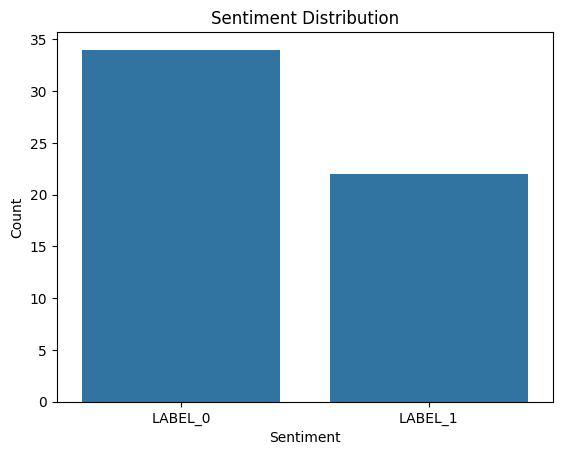

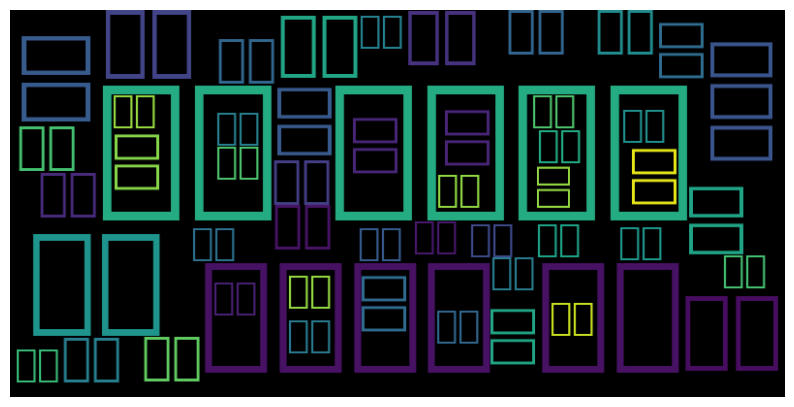

In [5]:
!sudo apt install fonts-dejavu-extra
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt
from wordcloud import WordCloud

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator")
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# 리뷰 데이터
texts = [
    "배공빠르고 굿",
    "택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고",
    "아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.",
    "선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..",
    "민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ",
    "비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적으로 보였는데 생각보다 진짜 별로입니다.",
    "주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고 아무런 연락을 받을수가 없으니 답답하신 분들은 다른곳에서 사시는거 추천드립니다",
    "넉넉한 길이로 주문했는데도 안 맞네요 별로예요",
    "보폴이 계속 때처럼 나오다가 지금은 안나네요~",
    "110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신축성없는 일반실로 되어있어 빅사이즈임에도 빅사이즈같지않아요. 입고벗을때 편하게 밴딩부분이 늘어나고 입었을때도 밴딩이 잡아주어야하는데 말이죠.",
    "사이즈도 딱이고 귀엽고 넘 좋아요 ㅎㅎ",
    "베이지 색 구매했는데 약간 살색에 가까워요",
    "화면빨인가봐요;; 노란컬러가 돋보여요;; 저렴한맛에 그냥 씁니다",
    "별루 ㅏㅛㅇ치ㅗ티ㅓ치ㅗ탛캏타ㅗ티ㅗ티ㅗ티ㅛ티ㅛ티ㅗㅗㅗ치ㅕ치ㅕ쳐ㅣ처ㅣ치ㅓ처ㅣ펴ㅣ쳐ㅣ치ㅕㅐㅛㅌ쵸ㅔ려ㅔㅎ",
    "촉감도 좋고 무게감이나 핏도 편합니다",
    "불멍하기좋고 사이즈도 너무 좋아요",
    "재구매 친구들이 좋은 향 난다고 해요",
    "실내에서 신는건지 몰랐어요",
    "재구매 다 좋은데 하나가 이상하네요",
    "가게를 운영하는 사장님께서 대신 구매 해달라고 하셔서 구매하게되었는데 가게에 달아놓으니까 이쁘네요",
    "가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜린데...",
    "화장이 깨끗하게 지워지지않아요 거품이생기고 오랫동안 문질러서 씻어내야하지만 세정력이 별로인듯해요",
    "남자 애들 인데 너무 좋아요 유해성분없어 초등들도 바르기좋아요",
    "채집통이 결착이 안됩니다. 채집통이 결착이 안되서 커터칼로 결착 부분과 모서리 부분을 깍아 냈더니 겨우 결착이 됩니다.해당 부분은 제품 불량 이슈 같구요 보내시기 전에 최소한의 테스트는 하고 보내주세요.",
    "재구매 늘 사는 흙이에요 팽이들이 젤 좋아해요 빠른배송 감사합니다",
    "처음 쓸때만 좋고 쓰다보니 의자뺄때 소리 계속 나요 그래서 붙이는부직포 덧붙였는데 여전히 끌리네요 비추에요 테니스공으로 살껄 이쁜거 산다고 이거 사서 후회되요",
    "배송기사나, 판매하는 회사나 불친절하고 불쾌합니다. 서비스면에선 최악이네요 제품은 그럭저럭 쓸만합니다. 싼게 비지떡 마인드부터 갖추고 장사하시길바랍니다. 이익에 눈",
    "저렴해서 구매 했지만 바지 완성도 떨어짐~~^^;",
    "사용이 불편하고 잘빠지네요ㅜ",
    "양은 많은데 맛은 없었습니다",
    "설치할때 전압이 넘 높아 퓨즈 나갔어여",
    "첨에받았을땐 너무튼튼하구 칸막이도있구 넘맘에들었는데요... 지금도맘에는들어요..근데....먼지가 먼지가 세상먼지다묻어요ㅠㅠ흑흑ㅠ 집에가만히 뒀는데도 먼지가다묻어있어요ㅠ 한번들고 그냥 모셔두었어요ㅜㅜ 까만색은 넘나비추입니다ㅠ 아이보리로살껄...ㅠ",
    "휴대폰 각이 잘 안나옴 노트9 사용 얇은 케이스 꺼도 잘 빠지지가 않네요 진짜 불편한건 각도가 조절이 너무 조금 된다는 점 입니다,,,,",
    "너무 생각보다 고급스럽",
    "가볍고 좋아요. 옵션에 파우치도 있었으면 얼마나 좋았을까 아쉽네요. 따로 구매 했어요. 잘 사용할께요.",
    "총 4개 샀는데,사용하기 전에 부드러운 물티슈로 닦았는데,프린트가 번졌네요 교환하기가 귀찮아서 그냥 쓰지만 아쉽네요",
    "모기가 않들어가요ᆢ",
    "선물준사람도 받은사람도 모두 만족했어요^^",
    "예쁘고 심플해서 샀는데. 재질이 깔끄러워요. 살에 자국 다 베이고ㅠㅠ....폭망이에요. 재대로 확인안한 제 잘못이죠;;; 참고로 싱글세트 2. 퀸세트 1 샀습니다.",
    "고정이 잘되기는 하는데 많이 쓰면 떡진것 처럼 보일까봐 걱정되서 많이 못쓰겠어요",
    "맛있어서 주문합니다. 카페갈 필요없음",
    "진짜 너무하시네요 배송이늦는건 엄절수없다하고 참앗지만 밑에 서랍이 금방 안되서 AS되냐고 물어봣는데 전화도 안받고 10시에 톡을보냇는데 오후6시에 답해서 뭐하나물어보려고하니 상담시간이아니라고 뜨네요 빨리as좀 해주세요 안되면 안된다고 답장부탁드립니다",
    "좋아요 색도 좋고 포근한 이불",
    "네이비 색상이 조금 진한듯 하지만 굿",
    "역시 기다린 보람이 있는 제품이군요!!",
    "퀄리티 가 좀떨어지고 손이따로노는것 같아요",
    "약간 삐뚤게 설치되네요.. 반품 귀찮아서 그냥 씁니다.",
    "피부 트러블 더 많이 올라와서 몸에 사용했는데 몸에도 뾰루지나네요ㅜ",
    "겁나 아픈데 익숙해지면 된다길래 몇일 했더니 발에 멍들고 고통이 너무 심하고 컨디션이 더 안좋아져서 결국 패기처분 했네요. 사람마다 다르니 사기전에 신중히 결정하세요. 참고로 전 평발아닙니다.",
    "아직 이유식 초기라 사용하지않았지만 후기보고 믿고 구매했습니다! 사이즈는 다양해서 너무 좋고요 실리콘재질이라 편하게 쓸거같아요",
    "사이즈가 딱이에요!! 오자마자 쪄 먹엇는뎅 달디달아요",
    "좀뻣뻣해서 애가 좋아하질않네요",
    "생각보다 너무 작아서요 나중에 먼지먹는식물이나 넣어야겠어요 물건은 흠없습니다",
    "세정력이 약해요. 처음사용할 땐 세제찌꺼기가 없어서 좋다고 했는데 2/3 사용해보니 너무 안씻겨요. 지멘스랑 안맞는건지.... 다시 쓰던 고체형으로 갈아탔습니다.",
    "흡착력이 너무 약해요..ㅠ 식판은 잘붙는데 이거는 애기가 자꾸 떼네요",
    "재구매 짱구오빠네 소개로 이용했는데 저번엔...",
]

# 감정 분석
results = [pipeline(text)[0] for text in texts]

# 한국어 불용어 제거를 위한 함수
okt = Okt()

def remove_stopwords(text):
    stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '에서', '과', '와', '로', '으로', '도', '만', '자', '다', '하', '고']  # 필요시 추가
    words = okt.nouns(text)
    return ' '.join([word for word in words if word not in stopwords])

# 불용어 처리 후 텍스트 벡터화
processed_texts = [remove_stopwords(text) for text in texts]

# TF-IDF 기반 키워드 추출 함수
vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(processed_texts)
terms = vectorizer.get_feature_names_out()

# 키워드 추출 함수
def extract_keywords(text_index, top_n=3):
    row = tfidf_matrix[text_index].toarray()[0]
    top_indices = np.argsort(row)[-top_n:][::-1]
    keywords = [(terms[i], row[i]) for i in top_indices]
    return keywords

# 분석 결과 데이터프레임 생성
data = {
    'Text': texts,
    'Sentiment': [result['label'] for result in results],
    'Score': [result['score'] for result in results],
    'Keywords': [extract_keywords(i) for i in range(len(texts))]
}

df_results = pd.DataFrame(data)

# 결과 출력
print(df_results)

# 감정 분포 시각화
sns.countplot(x='Sentiment', data=df_results)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


# 키워드 시각화 (WordCloud)
all_keywords = ' '.join([keyword[0] for sublist in df_results['Keywords'] for keyword in sublist])
# Use a font that is commonly available on Linux systems
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', width=800, height=400).generate(all_keywords)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()